In [ ]:
import os
import sys
import yaml
import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

import fabio
from pyFAI.geometry import Geometry
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.calibrant import get_calibrant

project_root = 'root'
sys.path.append(project_root)

In [6]:
from scripts.train import create_model, HDF5Dataset, MaxViTModel

sns.set_theme(style="whitegrid")

c:\Users\Hopkins\anaconda3\envs\maxima\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
CONFIG_PATH = "config.yaml" # The config used to train the final model
MODEL_PATH = "model.pth" # Path to your best trained model
HDF5_PATH = "dataset.hdf5" # Path to the dataset with the test split

# Load configuration
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

PARAM_NAMES = ["dist", "poni1", "poni2", "rot1", "rot2", "rot3"]
PARAM_UNITS = ["m", "m", "m", "rad", "rad", "rad"]

In [9]:
# Load model in inference mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = create_model(config)
state_dict = torch.load(MODEL_PATH, map_location=device)

# Handle potential `torch.compile` artifacts in the state_dict
if any(k.startswith('_orig_mod.') for k in state_dict.keys()):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[10:] if k.startswith('_orig_mod.') else k
        new_state_dict[name] = v
    state_dict = new_state_dict

model.load_state_dict(state_dict)
model.to(device)
model.eval();

Using device: cpu
Creating new model architecture from config...


In [10]:
image_size = config['model'].get('image_size', 224)
test_dataset = HDF5Dataset(HDF5_PATH, 'test', image_size=image_size)
test_loader = DataLoader(test_dataset, batch_size=config['training']['batch_size'], shuffle=False)

all_preds = []
all_labels = []

print("Running inference on the test set...")
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        predictions = model(images)
        
        all_preds.append(predictions.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

preds_np = np.concatenate(all_preds)
labels_np = np.concatenate(all_labels)

print("Inference complete.")

Running inference on the test set...


100%|██████████| 25/25 [30:13<00:00, 72.55s/it]

Inference complete.


In [ ]:
print("--- Performance Metrics on Test Set ---")
for i, name in enumerate(PARAM_NAMES):
    mae = mean_absolute_error(labels_np[:, i], preds_np[:, i])
    r2 = r2_score(labels_np[:, i], preds_np[:, i])
    print(f"{name:<6} (unit: {PARAM_UNITS[i]:<4}) | MAE: {mae:.6f} | R2: {r2:.4f}")

--- Performance Metrics on Test Set ---
dist   (unit: m   ) | MAE: 0.121345 | R²: 0.7111
poni1  (unit: m   ) | MAE: 0.031793 | R²: 0.0965
poni2  (unit: m   ) | MAE: 0.039721 | R²: -0.0300
rot1   (unit: rad ) | MAE: 0.007472 | R²: -55.7911
rot2   (unit: rad ) | MAE: 0.004035 | R²: -34.2191
rot3   (unit: rad ) | MAE: 0.012901 | R²: -167.9587


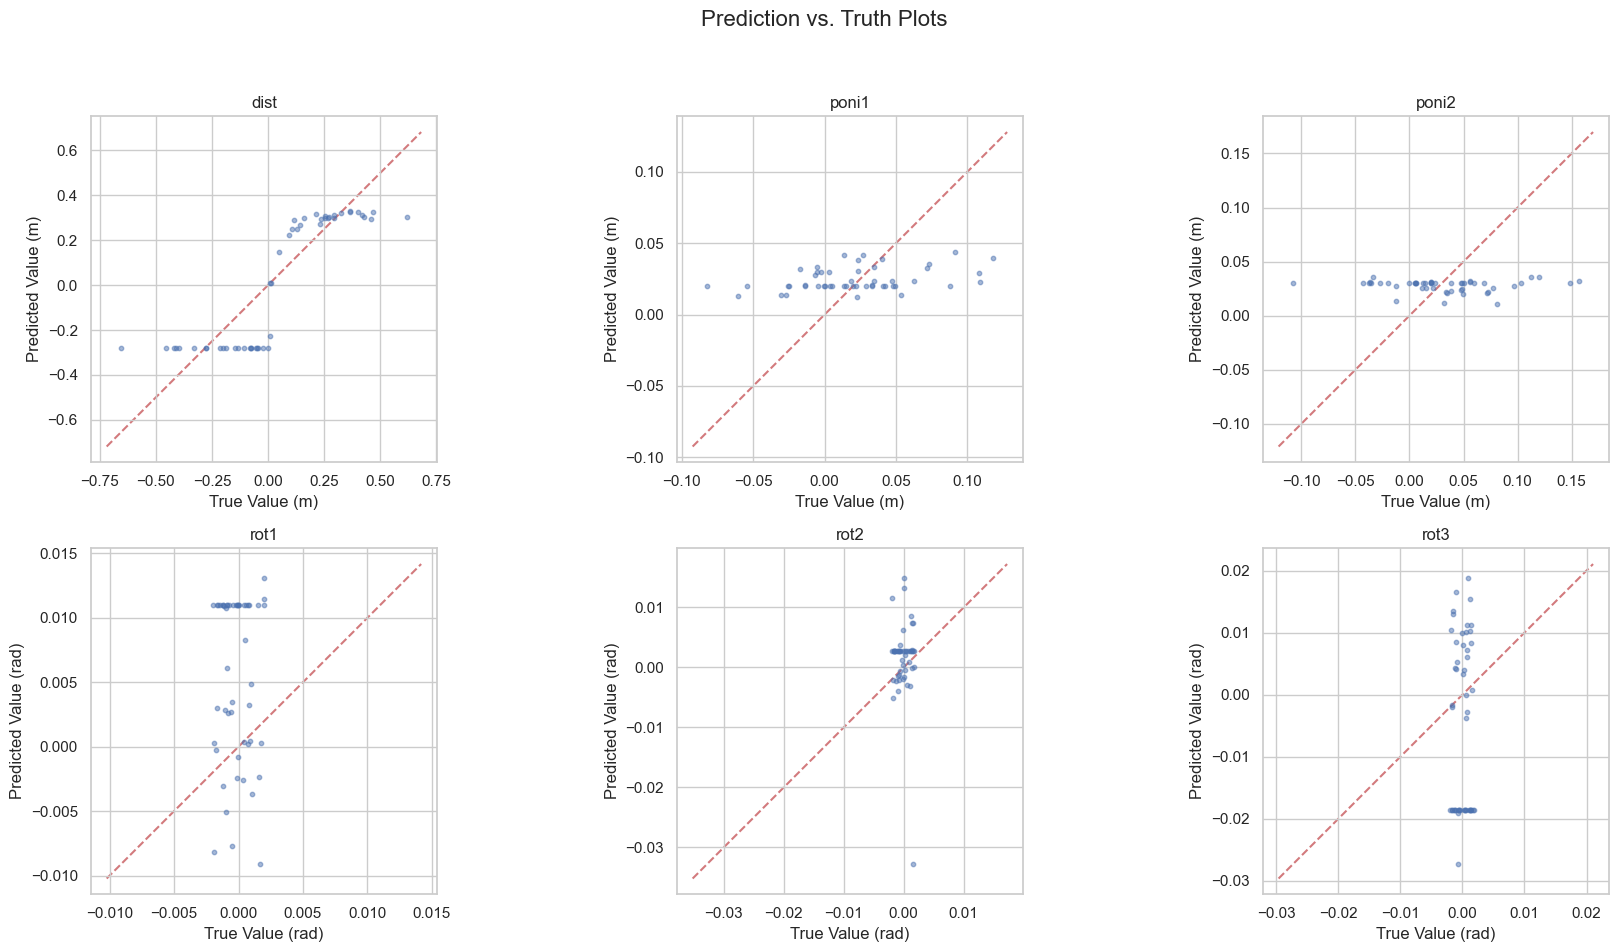

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Prediction vs. Truth Plots', fontsize=16)
axes = axes.flatten()

for i, (ax, name) in enumerate(zip(axes, PARAM_NAMES)):
    ax.scatter(labels_np[:, i], preds_np[:, i], alpha=0.5, s=10)
    
    # Add y=x line for reference
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_title(name)
    ax.set_xlabel(f"True Value ({PARAM_UNITS[i]})")
    ax.set_ylabel(f"Predicted Value ({PARAM_UNITS[i]})")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

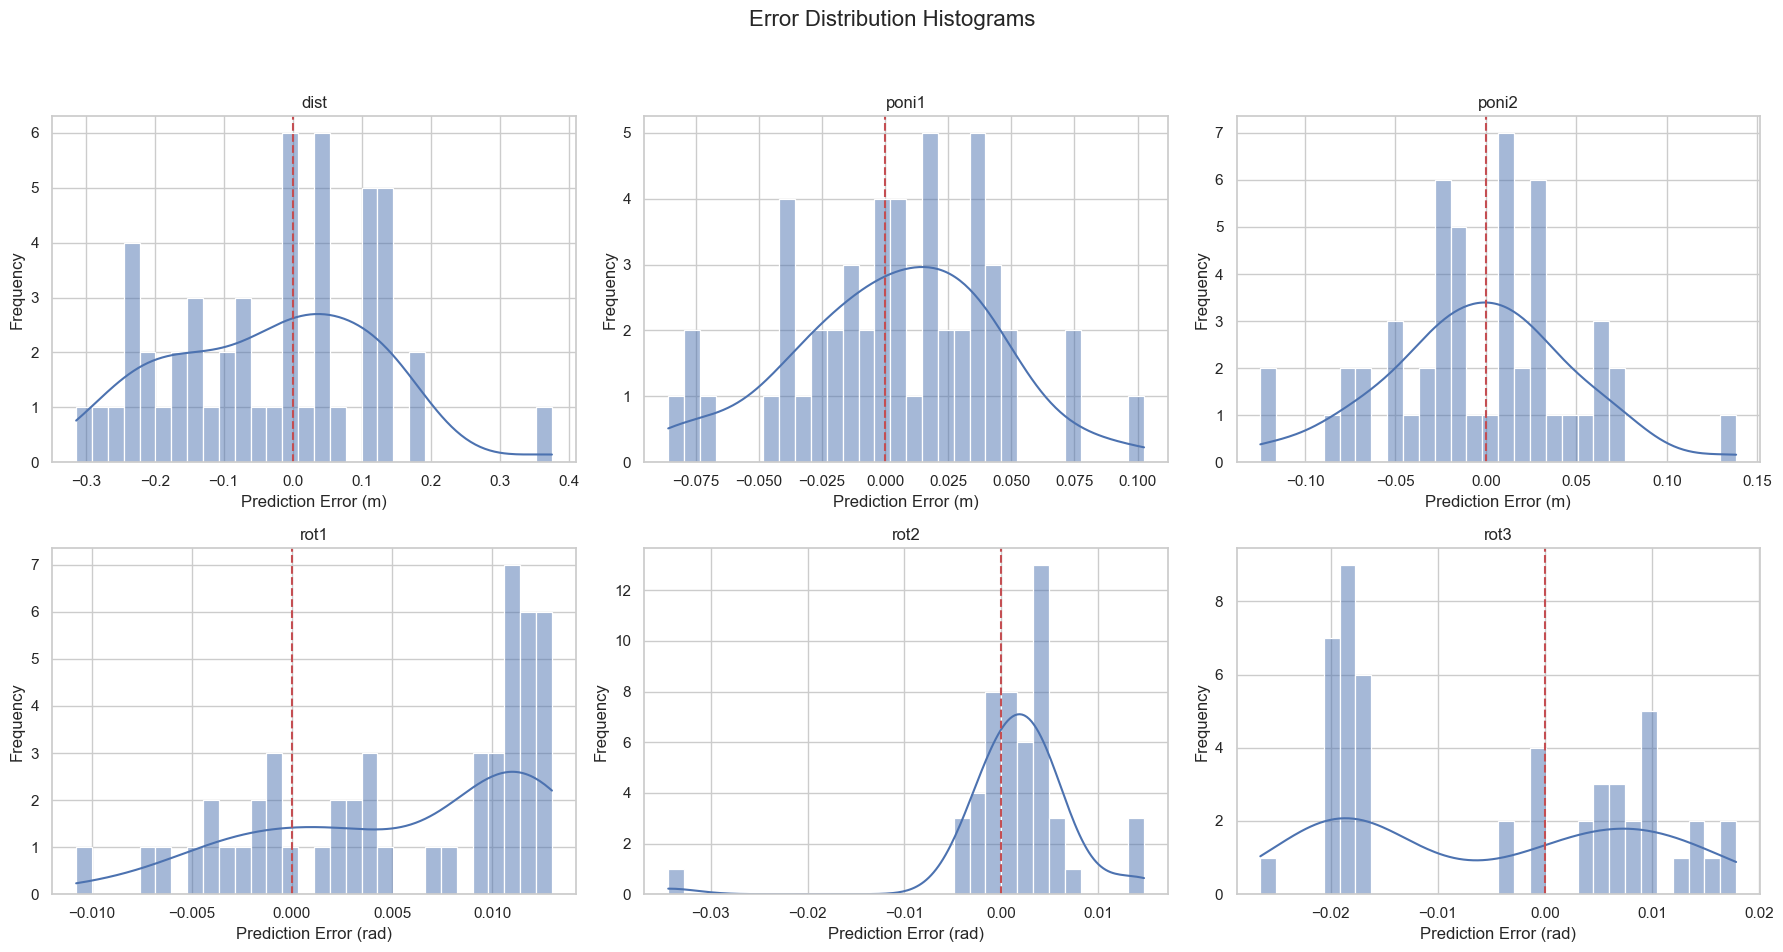

In [13]:
errors_np = preds_np - labels_np

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Error Distribution Histograms', fontsize=16)
axes = axes.flatten()

for i, (ax, name) in enumerate(zip(axes, PARAM_NAMES)):
    sns.histplot(errors_np[:, i], kde=True, ax=ax, bins=30)
    ax.axvline(0, color='r', linestyle='--')
    ax.set_title(name)
    ax.set_xlabel(f"Prediction Error ({PARAM_UNITS[i]})")
    ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

AttributeError: 'Calibrant' object has no attribute 'get_rings'

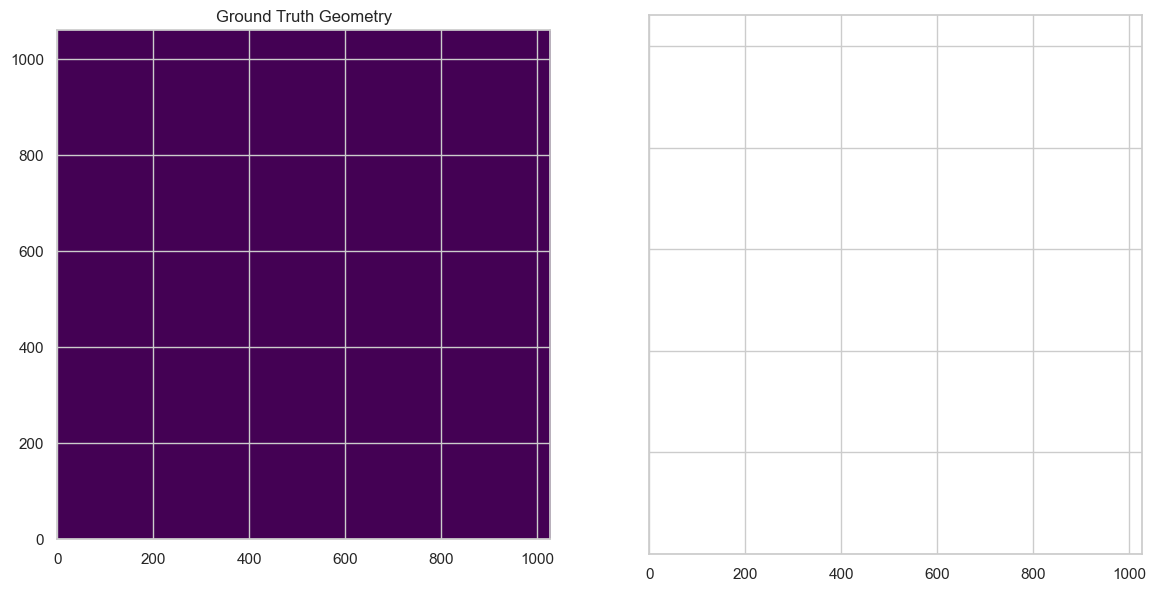

In [ ]:
def plot_ring_overlay(ax, image, geometry_params, calibrant, title):
    """Helper function to plot an image with calibration rings."""
    geom = Geometry(**geometry_params)
    # Use a log scale
    ax.imshow(np.log1p(image), cmap='gray', origin='lower')
    ax.set_title(title)
    
    for ring in calibrant.get_rings():
        tth = ring[0]
        geom.plot(tth, ax=ax, color='red', linewidth=0.5)

# Select a sample from the test set
sample_idx = 10 

with h5py.File(HDF5_PATH, 'r') as f:
    image_raw = f['test']['images'][sample_idx]

true_params_np = labels_np[sample_idx]
pred_params_np = preds_np[sample_idx]

# Create geometry dictionaries
true_geom_dict = {name: val for name, val in zip(PARAM_NAMES, true_params_np)}
pred_geom_dict = {name: val for name, val in zip(PARAM_NAMES, pred_params_np)}

# Get a calibrant object (ensure wavelength is set)
calibrant = get_calibrant("alpha_Al2O3")
calibrant.wavelength = 1.5406e-10 

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)
plot_ring_overlay(ax1, image_raw, true_geom_dict, calibrant, "Ground Truth Geometry")
plot_ring_overlay(ax2, image_raw, pred_geom_dict, calibrant, "Predicted Geometry")
plt.tight_layout()
plt.show()

In [ ]:
def integrate_pattern(image, geometry_params, calibrant, npt=2000):
    """Helper to perform 1D azimuthal integration."""

    detector = fabio.open(HDF5_PATH, 'r')['test']['images'].attrs.get('detector', 'default_detector_name') # placeholder
    ai = AzimuthalIntegrator(wavelength=calibrant.wavelength, **geometry_params)
    tth, intensity = ai.integrate1d(image, npt, unit="2th_deg")
    return tth, intensity

# Use the same sample as before
true_tth, true_I = integrate_pattern(image_raw, true_geom_dict, calibrant)
pred_tth, pred_I = integrate_pattern(image_raw, pred_geom_dict, calibrant)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(true_tth, true_I, label='Ground Truth Integration', linewidth=2)
plt.plot(pred_tth, pred_I, label='Predicted Integration', linestyle='--', linewidth=2)
plt.title(f"Comparison of 1D Integrated Patterns for Sample {sample_idx}")
plt.xlabel("2θ (degrees)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.grid(True)
plt.show()

NotGoodReader: HDF5 file does not contain an Eiger-like structure.

In [ ]:
# Close the HDF5 file handle
test_dataset.close()